# Particle Swarm Optimization

link: https://medium.com/towards-data-science/from-theory-to-practice-with-particle-swarm-optimization-using-python-5414bbe8feb6

_**"the information of a particle of a group can be used to inform all the other particles"**_

We can assume that the position of a particle (or a bird inside a flock) is determined by the positions based on 2 factors:

**1. Personal Best**: best position by the "specific particle"

**2. Global Best:**: global best position given by the result of "interaction" with other particles.


- While the article assumes the the individual to also pursue the best for the whole group, maybe game theory which assumes selfish individuals who maximize their own utility may also be applicable inside the following equations.

# Optimization problem

## Define the environment

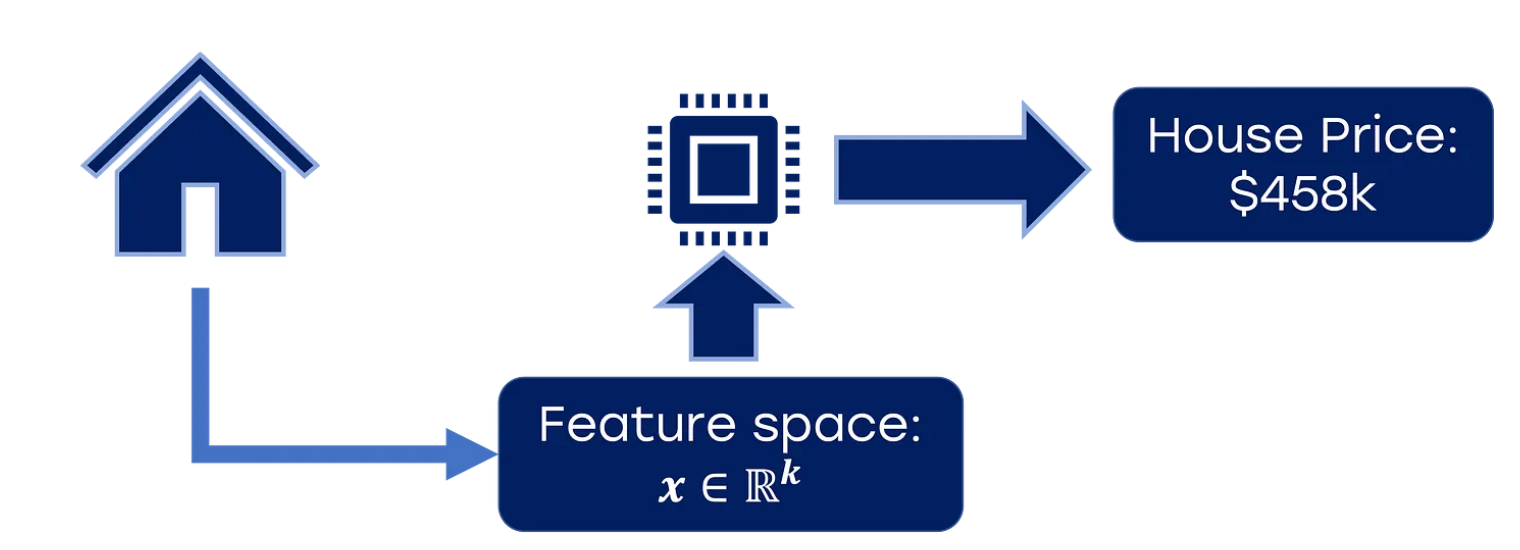

- The house is defined by a list of _**features**_

- each house is a k dimensional point of a feature space.

$$ x \in \mathbb{R}^{k} $$

- the black box process converts the Feature space into a house price (or cost function)

$$ L(x) : \mathbb{R}^k \rightarrow \mathbb{R} $$  

_여러 개의 변수로 이루어진 '집'이라는 행렬 벡터가 '가격'이라는 단일 스칼라로 변환된다_ 그게 solution space?

- The Optimzation defined under the environment above is as below:

$$ x_{min} = argminL(x)$$

## Define the Variables

- as shown above, $x$ determines the cost $L(x)$.
- Particle 1 will ahve location `x_1` and cost `L(x_1)`
- Another variable named velocity.
- for each dimension $i$ and each iteration $j$:
$$ x^{(j)}_i = x^{(j-1)}_i + v^{(j)} $$

- vector form:
$$ \mathbb{x}^{(j)}_i = \mathbb{x}^{(j-1)}_i + \mathbb{v}^{(j)} $$





## The components of $\mathbb{v}$:

$$\mathbb{v}^{(j)} = \mathbb{v}^{(j)}_{inertial} + \mathbb{v}^{(j)}_{cognitive} + \mathbb{v}^{(j)}_{social}$$

1. `v_inertal` is input by the previous velocity.

$$ \mathbb{v}^{(j)}_{inertial} = k_{inertial} \times \mathbb{v}^{(j-1)}_{inertial}  $$  

- k_{inertial}` is a constant which deciding the ratio of the former inertial to be reflected to the current inertial

2. `v_cognitive` is the velocity suggested by the particle:

$$\mathbb{v}^{j}_{cognitive} = k_{cognitive} \times r_1 \times (\mathbb{x}^{(j)}_{best} - \mathbb{x}^{(j-1)})$$

- `k_cognitive` is a constant. `x_best` is the best (lowest cost function) for the $x$ particle. (뭐야 게임 이론이랑 같잖아)
- `r_1` for some randomness

3. `v_social` is the gathered information from all the other particles. The direction that the entire group moves towards.

$$\mathbb{v}^{j}_{social} = k_{social} \times r_2 \times (\mathbb{x}^{(j)}_{global best} - \mathbb{x}^{(j-1)})$$

- `k` part is again a constant, global best is the lowest cost function for all the particles.


## Process

- start by selecting certain number of random particles

- move the particles based on the velocity parameters

- velocity is given by 3 factors: inertia, cognitive, and social

- repeat the process untile `num_iteration`

## Create PSO Model

2 classes:

1. Single Particle class

2. Swarm class

In [2]:
# constants.py 파일 생성
# 'config/pso_config.json' 이 json 파일로 저장한다?

NUM_PARTICLES = 30
NUM_ITERATIONS = 100

# velocity에 대해 상수로 정의되는 것을 알 수 있다!
INERTIA = 0.5
COGNITIVE = 2
SOCIAL = 2

BOUNDS = [[-10,10],[-10,10]]

CONFIG_FILENAME = 'config/pso_config.json'

DEFAULT_CONFIG_NAMES = ["num_particles", "num_iterations", "inertia", "cognitive", "social", "bounds"]
DEFAULT_PARTICLE = [NUM_PARTICLES, NUM_ITERATIONS, INERTIA, COGNITIVE, SOCIAL, BOUNDS]

In [3]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# 여기서 개별 particle을 정의한다
class Particle:
    def __init__(self, bounds):
        # x
        self.position = np.array([np.random.uniform(low, high) for low, high in bounds])
        # v
        self.velocity = np.zeros_like(self.position)
        # 개별 particle의 best이다!!
        self.best_position = np.copy(self.position)
        self.best_value = float('inf')

    # 벡터 v 를 정의하고 다음 차수의 v를 구함.
    def update_velocity(self, global_best_position, inertia, cognitive, social):
        r1 = np.random.random(len(self.position))
        r2 = np.random.random(len(self.position))

        # v_cognitive
        cognitive_velocity = cognitive * r1 * (self.best_position - self.position)

        # v_social
        social_velocity = social * r2 * (global_best_position - self.position)

        # former velocity is also one of the variables for the next velocity
        self.velocity = inertia * self.velocity + cognitive_velocity + social_velocity

    def update_position(self, bounds):

        # position은 결국 position + velocity 니까
        self.position += self.velocity

        # 상한 하한을 정해둔다.
        for i in range(len(self.position)):

            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]

            if self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]


# 개별 particle의 정의도 활용하고, 전체 swarm도 사용한다.
class ParticleSwarmOptimizer:
    def __init__(self, particle_class, objective_function, config_filename = None):

        # 위에서 정의한 개별 Particle 객체를 가져온다.
        self.particle_class = particle_class
        if config_filename is None:
            self.config = self.load_or_create_config()
        else:
            self.config = self.load_or_create_config(config_filename)

        # objective function을 optimization의 평가에 사용한다.
        # 이게 rule-base 대신에
        self.objective_function = objective_function

        # 한번에 움직일 수 있는 움직임 제약
        self.bounds = self.config['bounds']

        # particle의 개수
        self.num_particles = self.config['num_particles']

        # 움직임 횟수
        self.num_iterations = self.config['num_iterations']

        # velocity의 세부 요소, 하나는 이전 velocity라 정의 X
        self.inertia = self.config['inertia']
        self.cognitive = self.config['cognitive']
        self.social = self.config['social']

        # 군집
        self.swarm = [self.particle_class(self.bounds) for _ in range(self.num_particles)]

        # 군집의 best를 저장한다
        self.global_best_position = np.copy(self.swarm[0].position)
        self.global_best_value = float('inf')

    def load_or_create_config(self, filename=CONFIG_FILENAME):
        # 파일을 불러오기 전에 이렇게 존재여부를 먼저 확인할 수 있다!
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                config = json.load(f)
                print("Loaded configuration from", filename)
        else:
            with open(filename, 'w') as f:
                default_config = {DEFAULT_CONFIG_NAMES[i]:DEFAULT_PARTICLE[i] for i in range(len(DEFAULT_PARTICLE))}
                json.dump(default_config, f, indent=4)
                config = default_config
                print(f"Configuration file not found. Created default config at {filename}")

        return config

    def optimize(self, save_iterations=False, print_iterations=False):
        # 각 회차마다 best 를 저장
        if save_iterations:
            best_values_per_iteration = np.zeros(self.num_iterations)
            best_positions_per_iteration = np.zeros((self.num_iterations, len(self.bounds)))
            all_positions_per_iteration = np.zeros((self.num_iterations, self.num_particles, len(self.bounds)))

        for iteration in range(self.num_iterations):
            # 군집 내의 particle에 대해서
            for i, particle in enumerate(self.swarm):
                # 목적함수를 통과하는 position, 그걸로 오차값? 비용 값을 구한다 (최소화 해야한다)
                value = self.objective_function(particle.position)

                # 이거는 개별 particle의 best 저장, 그래서 현재 particle에 저장된다
                if value < particle.best_value:
                    particle.best_value = value
                    particle.best_position = np.copy(particle.position)

                # global best 저장, 그래서 class 전체, self에 저장된다!
                if value < self.global_best_value:
                    self.global_best_value = value
                    self.global_best_position = np.copy(particle.position)

                if save_iterations:
                    all_positions_per_iteration[iteration, i] = particle.position

            if save_iterations:
                best_values_per_iteration[iteration] = self.global_best_value
                best_positions_per_iteration[iteration] = np.copy(self.global_best_position)

            for particle in self.swarm:

                # 상단의 update를 사용해서
                particle.update_velocity(self.global_best_position, self.inertia, self.cognitive, self.social)
                particle.update_position(self.bounds)

            if print_iterations:
                print(f"Iteration {iteration+1}/{self.num_iterations}, Global Best Value: {self.global_best_value}")

        # 최적화 결과 출력
        if save_iterations:
            self.best_values_per_iteration = best_values_per_iteration
            self.best_positions_per_iteration = best_positions_per_iteration
            self.all_positions_per_iteration = all_positions_per_iteration
            return self.global_best_position, self.global_best_value, self.best_values_per_iteration, self.best_positions_per_iteration, self.all_positions_per_iteration
        else:
            return self.global_best_position, self.global_best_value, None, None, None

    def plot_pso_convergence(self, animated=False, gif_name="pso_convergence.gif"):
        """
        contour plot로 목적함수의 수렴 과정을 묘사한다.

        Parameters:
        - objective_function: 목적 함수를 contour plot으로 표현한다.
        - animated: gif로 수렴 과정을 표현해준다!
        - gif_name: gif의 이름
        """
        if not hasattr(self, 'all_positions_per_iteration'):
            raise ValueError("No iteration data available. Run optimize with save_iterations=True first.")

        objective_function = self.objective_function
        iteration_values = self.best_values_per_iteration
        iteration_positions = self.all_positions_per_iteration

        # grid를 생성한다, bound를 기준으로 한다!
        # x의 상한하한, y의 상한하한
        x = np.linspace(self.bounds[0][0], self.bounds[0][1], 100)
        y = np.linspace(self.bounds[1][0], self.bounds[1][1], 100)
        X, Y = np.meshgrid(x,y)
        Z = np.array([[objective_function([x_val, y_val]) for x_val in x] for y_val in y])

        if animated:
            fig, ax = plt.subplots()

            contour = ax.contourf(X, Y, Z, levels = 50, cmap='viridis')
            plt.colorbar(contour, ax=ax)

            particles = ax.scatter([], [], c='blue', label="Particles", s= 50)
            global_best = ax.scatter([], [], c='red', label="Global Best", s=100, marker='x')

            ax.set_title("PSO Particle Movement and Convergence")
            ax.set_xlabel("X Position")
            ax.set_ylabel("Y Position")
            ax.legend()

            def init():
                particles.set_offsets(np.empty((0, 2)))
                global_best.set_offsets(np.empty((0, 2)))
                return particles, global_best

            def update(frame):
                current_positions = iteration_positions[frame]
                particles.set_offsets(current_positions)
                global_best.set_offsets(self.best_positions_per_iteration[frame:frame+1])
                return particles, global_best

            ani = animation.FuncAnimation(fig, update, frames=len(iteration_positions), init_func=init, blit=True, repeat=False)

            ani.save(gif_name, writer='pillow', fps=5)
            print(f"Animation saved as {gif_name}")
            plt.close(fig)

        else:
            fig, ax = plt.subplots()

            contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
            plt.colorbar(contour, ax=ax)

            plt.plot(iteration_values, marker='o', linestyle='-', color='b')
            plt.title("PSO Convergence Plot")
            plt.xlabel("Iterations")
            plt.ylabel("Global Best Value")
            plt.grid(True)
            plt.show()

ModuleNotFoundError: No module named 'numpy'

# Application

- simple quadratic function:

$$f(x) = x^2_0 + x^2_1 + 50$$

In [4]:
import numpy as np
import json
import os
#from particle_swarm_optimizer import *

def quadratic_objective_function(x):
    return x[0]**2 + x[1]**2 + 50

pso = ParticleSwarmOptimizer(Particle, quadratic_objective_function)
best_position, best_value, iteration_values, iteration_positions, all_positions = pso.optimize(save_iterations=True, print_iterations=False)
print("Best Position:", best_position)
print("Best Value:", best_value)
pso.plot_pso_convergence(animated=True)

ModuleNotFoundError: No module named 'numpy'

- more complex objective function
$$f(x) = (x^2_0+x^ 2_1) - 10 \cdot \sin(x_0) \cdot \sin(4x_1) + 5 \cdot \exp(-0.1\cdot(x^2_0+x^2_1)) + 20$$



In [1]:
def complex_objective_function(x):
    term1 = (x[0]**2 + x[1]**2)
    term2 = 10 * np.sin(x[0]) * np.sin(4*x[1])
    term3 = np.exp(-0.1 * (x[0]**2 + x[1]**2))
    return term1 - term2 + 5 * term3 + 20

pso = ParticleSwarmOptimizer(Particle, complex_objective_function)
best_position, best_value, iteration_values, iteration_positions, all_positions = pso.optimize(save_iterations=True, print_iterations=False)
print("Best Position:", best_position)
print("Best Value:", best_value)
pso.plot_pso_convergence(animated=True)

SyntaxError: expected ':' (305000026.py, line 1)